In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rnd
from tqdm import tqdm_notebook #gives a progress bar

# visualizatoin
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
plt.style.use('ggplot')

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Import standard data from competition
categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")

test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

# Import data from the Feature Engineering Notebook

train_table = pd.read_csv('../input/predict-future-sales-feature-engineering/Table_Train.csv')

traintest = pd.read_csv('../input/predict-future-sales-feature-engineering/Traintest.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,6,10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


For this notebook we will separate the data and encode it. Then we will start building models to determine which features are most important. Then we will split the data for validation. Then we will start training the features using the data and validate it. 

We will create pipelines to do this in an efficient manner. Hopefully pipelines for splitting data, models, training it, and getting the validation scores.

Change item_cnt_day to item_cnt_month

In [2]:
traintest = traintest.rename(columns = {'item_cnt_day': 'item_cnt_month'})

In [3]:
traintest.head()

,Month,date,date_block_num,item_category_id,item_cnt_month,item_id,item_name,item_price,m_num,shop_id,shop_name,Revenue,item_category_name_,cats,cat
0,Jan,2013-01-02,0.0,37.0,1.0,22154,ЯВЛЕНИЕ 2012 (BD),999.00,1.0,59,"Ярославль ТЦ ""Альтаир""",999.00,Кино - Blu-Ray,Movie,7.0
1,Jan,2013-01-03,0.0,58.0,1.0,2552,DEEP PURPLE The House Of Blue Light LP,899.00,1.0,25,"Москва ТРК ""Атриум""",899.00,Музыка - Винил,Music,9.0
2,Jan,2013-01-06,0.0,58.0,1.0,2554,DEEP PURPLE Who Do You Think We Are LP,1709.05,1.0,25,"Москва ТРК ""Атриум""",1709.05,Музыка - Винил,Music,9.0
3,Jan,2013-01-15,0.0,56.0,1.0,2555,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),1099.00,1.0,25,"Москва ТРК ""Атриум""",1099.00,Музыка - CD фирменного производства,Music,9.0
4,Jan,2013-01-10,0.0,59.0,1.0,2564,DEEP PURPLE Perihelion: Live In Concert DVD (К...,349.00,1.0,25,"Москва ТРК ""Атриум""",349.00,Музыка - Музыкальное видео,Music,9.0


### Split Train and Test Data

In [4]:
traintest.tail()

,Month,date,date_block_num,item_category_id,item_cnt_month,item_id,item_name,item_price,m_num,shop_id,shop_name,Revenue,item_category_name_,cats,cat
3139272,Nov,NaN,34.0,NaN,NaN,18454,NaN,NaN,11.0,45,NaN,NaN,NaN,NaN,NaN
3139273,Nov,NaN,34.0,NaN,NaN,16188,NaN,NaN,11.0,45,NaN,NaN,NaN,NaN,NaN
3139274,Nov,NaN,34.0,NaN,NaN,15757,NaN,NaN,11.0,45,NaN,NaN,NaN,NaN,NaN
3139275,Nov,NaN,34.0,NaN,NaN,19648,NaN,NaN,11.0,45,NaN,NaN,NaN,NaN,NaN
3139276,Nov,NaN,34.0,NaN,NaN,969,NaN,NaN,11.0,45,NaN,NaN,NaN,NaN,NaN


In [5]:
test_data = traintest[traintest['date_block_num'] == 34]
test_data.head()

,Month,date,date_block_num,item_category_id,item_cnt_month,item_id,item_name,item_price,m_num,shop_id,shop_name,Revenue,item_category_name_,cats,cat
2925077,Nov,NaN,34.0,NaN,NaN,5037,NaN,NaN,11.0,5,NaN,NaN,NaN,NaN,NaN
2925078,Nov,NaN,34.0,NaN,NaN,5320,NaN,NaN,11.0,5,NaN,NaN,NaN,NaN,NaN
2925079,Nov,NaN,34.0,NaN,NaN,5233,NaN,NaN,11.0,5,NaN,NaN,NaN,NaN,NaN
2925080,Nov,NaN,34.0,NaN,NaN,5232,NaN,NaN,11.0,5,NaN,NaN,NaN,NaN,NaN
2925081,Nov,NaN,34.0,NaN,NaN,5268,NaN,NaN,11.0,5,NaN,NaN,NaN,NaN,NaN


In [6]:
test_data.shape

(214200, 15)

In [7]:
train = traintest[traintest['date_block_num'] < 34]
train.tail()

,Month,date,date_block_num,item_category_id,item_cnt_month,item_id,item_name,item_price,m_num,shop_id,shop_name,Revenue,item_category_name_,cats,cat
2925072,Oct,2015-10-10,33.0,55.0,1.0,7409,V/A Nu Jazz Selection (digipack),299.0,10.0,25,"Москва ТРК ""Атриум""",299.0,Музыка - CD локального производства,Music,9.0
2925073,Oct,2015-10-09,33.0,55.0,1.0,7460,V/A The Golden Jazz Collection 1 2CD,299.0,10.0,25,"Москва ТРК ""Атриум""",299.0,Музыка - CD локального производства,Music,9.0
2925074,Oct,2015-10-14,33.0,55.0,1.0,7459,V/A The Best Of The 3 Tenors,349.0,10.0,25,"Москва ТРК ""Атриум""",349.0,Музыка - CD локального производства,Music,9.0
2925075,Oct,2015-10-22,33.0,57.0,1.0,7440,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),299.0,10.0,25,"Москва ТРК ""Атриум""",299.0,Музыка - MP3,Music,9.0
2925076,Oct,2015-10-03,33.0,55.0,1.0,7460,V/A The Golden Jazz Collection 1 2CD,299.0,10.0,25,"Москва ТРК ""Атриум""",299.0,Музыка - CD локального производства,Music,9.0


In [8]:
train.isnull().sum(axis=0).head(20)

Month                      0
date                       0
date_block_num             0
item_category_id           0
item_cnt_month             0
item_id                    0
item_name                  0
item_price                 0
m_num                      0
shop_id                    0
shop_name                  0
Revenue                    0
item_category_name_        0
cats                       0
cat                    45086
dtype: int64

In [9]:
train.shape

(2925077, 15)

#### Make Table

Go ahead and train the data with just this table and see how well it does.

In [10]:
train_df = train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_month',aggfunc='sum').fillna(0.0)
train_df.head()

date_block_num   0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
shop_id item_id                                                               
0       30        0.0  31.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        31        0.0  11.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        32        6.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        33        3.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        35        1.0  14.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

date_block_num   ...  24.0  25.0  26.0  27.0  28.0  29.0  30.0  31.0  32.0  \
shop_id item_id  ...                                                         
0       30       ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        31       ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        32       ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        33       ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        35       ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

date_block_num   33.0  
shop_id item_id        
0       30        0.0  
        31        0.0  
        32        0.0  
        33        0.0  
        35        0.0  

[5 rows x 34 columns]

All of the missing values were converted to zero in the table. 

In [11]:
train_df = train_df.reset_index()

In [12]:
train_df.head()

date_block_num,shop_id,item_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split the Data

We split the data into separate training and validation sets

The only problem is that our test set of data to train is only the one column of data. We could probably combine it with the train data and fill in the missing values with zeros. Then we could train on the entire set and try to predict the missing values. Yes! This would work. It would train the model on the whole training data and try to predict the missing value.

We just tested it on the training data by excluding the last column as the test data for validation. 

In [13]:
from sklearn.model_selection import train_test_split
X = train_df.iloc[:, 0:35]
y = train_df.iloc[:, 35]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_val.shape)

(284140, 35) (139951, 35)


In [14]:
#X_train.head()
y_train.head()
#X_val.head()

139527    0.0
421986    0.0
224036    0.0
262392    0.0
99603     0.0
Name: 33.0, dtype: float64

### Determining Feature Importance


In [15]:
# Train with XGBoost
param = {'max_depth': 10, 'eta': 0.10,
         'seed': 1,
         'eval_metric': 'rmse'}
# Split data
a = train_df.iloc[:, 0:35]
b = train_df.iloc[:, 35]
# Train
xgbtrain = xgb.DMatrix(a, b)
watchlist = [(xgbtrain, 'train-rmse')]

bst = xgb.train(param, xgbtrain)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


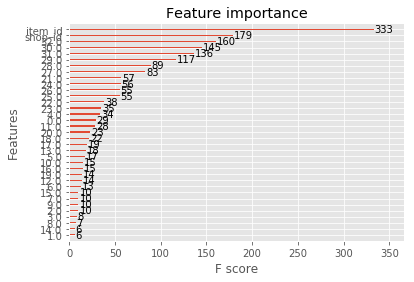

In [16]:
# Determine importance of features with XGB graph
xgb.plot_importance(bst)

This graph shows that the most important features from the table are the item_id and shop_id. This doesn't seem right, so maybe we should drop those?
Since these are just time series data it makes sense that the shop_id and item_id would be the first thing the model looks to and the most predictive feature

But after that the importance of the item goes from the most recent month to the furthest.

### Running XGBoost Model

In [17]:
param = {'max_depth': 10, 'eta': 0.10,
         'seed': 1,
         'eval_metric': 'rmse'}

# Train
xgbtrain = xgb.DMatrix(X_train, y_train)
watchlist = [(xgbtrain, 'train-rmse')]

bst = xgb.train(param, xgbtrain)
pred = bst.predict(xgb.DMatrix(X_val))
# Find the mean squared error
rmse = np.sqrt(mean_squared_error(pred,y_val))         

print(rmse)

1.0028965628152917


#### Try splitting the data using only the montly sales and have many different folds. 

We have to put the data into arrays of values instead of dataframe because XGBoost cannot take in the dataframes where the columns have different labels.

Test different folds. Each fold is from January to October and we are predicting November

In [18]:
# The many different folds
# Separate and tranform to arrays not dataframes
X1 = train_df.values[:, 2:12]
y1 = train_df.values[:, 12] # November

X2 = train_df.values[:, 14: 24]
y2 = train_df.values[:, 24] # November

X3 = train_df.values[:, 2:34]
y3 = train_df.values[:, 34] # October

X4 = train_df.values[:, 3:35]
y4 = train_df.values[:, 35]


In [19]:
# XGBoost
param = {'max_depth': 10, 'eta': 0.10,
         'seed': 1,
         'eval_metric': 'rmse'}

# Train
xgbtrain = xgb.DMatrix(X3, y3)
watchlist = [(xgbtrain, 'train-rmse')]
bst = xgb.train(param, xgbtrain)
pred1 = bst.predict(xgb.DMatrix(X4))
# Find the mean squared error
rmse = np.sqrt(mean_squared_error(pred1,y4))         

print(rmse)

1.2814874289063798


Using the total train data (months 1-32) to train and then validating with months (2-33), we get an rmse of 1.1435. So this shows us that the more data and months we use the better the validation scores. Now we are going to submit to see if it is overfitting. 

Using first Jan-Oct(X1), the November(y2) prediction has a RMSE of 1.6026

Using the second Jan-Oct(X2), the November(y1) prediction has an RMSE of 1.73597

This gives us a more realistic look at what the score would be like if we trained on this data. I predict it will be around 1.8-2.2 rmse.  

### Test

First drop all the trian items that are not also in test dataset

In [20]:
test_shop_ids = test_data['shop_id'].unique()
test_item_ids = test_data['item_id'].unique()
# Only shops that exist in test set.
t_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
t_train = t_train[t_train['item_id'].isin(test_item_ids)]


In [21]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', t_train.shape[0])

Data set size before leaking: 2925077
Data set size after leaking: 1219335


Combine the new test and train data

In [22]:
traintest_t = pd.concat([t_train, test_data], axis=0)
traintest_t.head()

,Month,date,date_block_num,item_category_id,item_cnt_month,item_id,item_name,item_price,m_num,shop_id,shop_name,Revenue,item_category_name_,cats,cat
0,Jan,2013-01-02,0.0,37.0,1.0,22154,ЯВЛЕНИЕ 2012 (BD),999.0,1.0,59,"Ярославль ТЦ ""Альтаир""",999.0,Кино - Blu-Ray,Movie,7.0
9,Jan,2013-01-03,0.0,55.0,2.0,2574,DEL REY LANA Born To Die The Paradise Editio...,399.0,1.0,25,"Москва ТРК ""Атриум""",798.0,Музыка - CD локального производства,Music,9.0
10,Jan,2013-01-05,0.0,55.0,1.0,2574,DEL REY LANA Born To Die The Paradise Editio...,399.0,1.0,25,"Москва ТРК ""Атриум""",399.0,Музыка - CD локального производства,Music,9.0
11,Jan,2013-01-07,0.0,55.0,1.0,2574,DEL REY LANA Born To Die The Paradise Editio...,399.0,1.0,25,"Москва ТРК ""Атриум""",399.0,Музыка - CD локального производства,Music,9.0
12,Jan,2013-01-08,0.0,55.0,2.0,2574,DEL REY LANA Born To Die The Paradise Editio...,399.0,1.0,25,"Москва ТРК ""Атриум""",798.0,Музыка - CD локального производства,Music,9.0


In [23]:
traintest_t.tail()

,Month,date,date_block_num,item_category_id,item_cnt_month,item_id,item_name,item_price,m_num,shop_id,shop_name,Revenue,item_category_name_,cats,cat
3139272,Nov,NaN,34.0,NaN,NaN,18454,NaN,NaN,11.0,45,NaN,NaN,NaN,NaN,NaN
3139273,Nov,NaN,34.0,NaN,NaN,16188,NaN,NaN,11.0,45,NaN,NaN,NaN,NaN,NaN
3139274,Nov,NaN,34.0,NaN,NaN,15757,NaN,NaN,11.0,45,NaN,NaN,NaN,NaN,NaN
3139275,Nov,NaN,34.0,NaN,NaN,19648,NaN,NaN,11.0,45,NaN,NaN,NaN,NaN,NaN
3139276,Nov,NaN,34.0,NaN,NaN,969,NaN,NaN,11.0,45,NaN,NaN,NaN,NaN,NaN


This is how to make an output from an xgboost prediction

In [24]:
# get traintest data into table to run model on
traintest_t_df = traintest_t.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_month',aggfunc='sum').fillna(0.0)
traintest_t_df.head()

date_block_num   0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
shop_id item_id                                                               
2       30        0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
        31        0.0   4.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
        32        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        33        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        38        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

date_block_num   ...  25.0  26.0  27.0  28.0  29.0  30.0  31.0  32.0  33.0  \
shop_id item_id  ...                                                         
2       30       ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        31       ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
        32       ...   0.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
        33       ...   1.0   0.0   1.0   1.0   0.0   1.0   0.0   1.0   0.0   
        38       ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

date_block_num   34.0  
shop_id item_id        
2       30        0.0  
        31        0.0  
        32        0.0  
        33        0.0  
        38        0.0  

[5 rows x 35 columns]

In [25]:
traintest_t_df = traintest_t_df.reset_index()

In [26]:
traintest_t_df.head()

date_block_num,shop_id,item_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0
0,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
tt_df = traintest_t_df.reset_index()
tt_df.head()

date_block_num,index,shop_id,item_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,...,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0
0,0,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,2,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4,2,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Split data and turn into values
Xi = tt_df.values[:, 3:35]
yi = tt_df.values[:, 35] # October

Xt = tt_df.values[:, 5:37]

In [29]:
#XGBoost
param = {'max_depth': 10, 'eta': 0.10,
         'seed': 1,
         'eval_metric': 'rmse'}

# Train
xgbtrain = xgb.DMatrix(Xi, yi)
watchlist = [(xgbtrain, 'train-rmse')]
bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(Xt))

In [30]:
# prediction output
sub_df = pd.DataFrame({'ID':tt_df.index,'item_cnt_month': preds })
sub_df.head()

,ID,item_cnt_month
0,0,0.242148
1,1,0.377615
2,2,0.296887
3,3,0.333156
4,4,0.242148


In [31]:
# Normalize predictions from [0, 20] range
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
subs_df = pd.DataFrame({'ID':tt_df.index,'item_cnt_month': preds })
sub_df.head()

,ID,item_cnt_month
0,0,0.242148
1,1,0.377615
2,2,0.296887
3,3,0.333156
4,4,0.242148


Output: Submission

In [32]:
subs_df.to_csv('Pract_Sub_PredictFutureSales.csv', index=False)

We need to make a model that we can train to always predict the next month's data and then put in any monthly sales data and make it spit out whatever the next month will be. 

## Split Training Set

Create new dataset by dropping features

In [33]:
"""
train_clean = train.drop(['date', 'Month', 'item_name', 'shop_name', 'item_category_name_', 
                         'cats', 'Revenue', 'cat', 'item_price','item_category_id'], axis=1)
train_clean.head()
"""

"\ntrain_clean = train.drop(['date', 'Month', 'item_name', 'shop_name', 'item_category_name_', \n                         'cats', 'Revenue', 'cat', 'item_price','item_category_id'], axis=1)\ntrain_clean.head()\n"

In [34]:
#train_clean.isnull().sum(axis=0).head(10)

Split training data along the month column. Split it as time series; not by item_id.

In [35]:
""" 
train_set_1 = train_clean.query('date_block_num >= 0 and date_block_num < 25').copy()
validation_set_1 = train_clean.query('date_block_num == 25').copy()
train_set_2 = train_clean.query('date_block_num >=0 and date_block_num < 29').copy()
validation_set_2 = train_clean.query('date_block_num == 29').copy()
train_set_3 = train_clean.query('date_block_num >= 0 and date_block_num < 30').copy()
validation_set_3 = train_clean.query('date_block_num == 30').copy()
test_set = train_clean.query('date_block_num == 33').copy()

print('Train set records:', train_set_1.shape[0])
print('Validation set records:', validation_set_1.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_clean.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_clean.shape[0])*100)))
"""

" \ntrain_set_1 = train_clean.query('date_block_num >= 0 and date_block_num < 25').copy()\nvalidation_set_1 = train_clean.query('date_block_num == 25').copy()\ntrain_set_2 = train_clean.query('date_block_num >=0 and date_block_num < 29').copy()\nvalidation_set_2 = train_clean.query('date_block_num == 29').copy()\ntrain_set_3 = train_clean.query('date_block_num >= 0 and date_block_num < 30').copy()\nvalidation_set_3 = train_clean.query('date_block_num == 30').copy()\ntest_set = train_clean.query('date_block_num == 33').copy()\n\nprint('Train set records:', train_set_1.shape[0])\nprint('Validation set records:', validation_set_1.shape[0])\nprint('Test set records:', test_set.shape[0])\n\nprint('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_clean.shape[0])*100)))\nprint('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_clean.shape[0])*100)))\n"

#### Prepare for Model


In [36]:
"""
X_train1 = train_set_1.drop('item_cnt_month', axis=1)
Y_train1 = train_set_1['item_cnt_month']

X_train2 = train_set_2.drop('item_cnt_month', axis=1)
Y_train2 = train_set_2['item_cnt_month']

X_train3 = train_set_3.drop('item_cnt_month', axis=1)
Y_train3 = train_set_3['item_cnt_month']

# Validation Set
X_val1 = validation_set_1.drop('item_cnt_month', axis=1)
Y_val1 = validation_set_1['item_cnt_month']

X_val2 = validation_set_2.drop('item_cnt_month', axis=1)
Y_val2 = validation_set_2['item_cnt_month']

X_val3 = validation_set_3.drop('item_cnt_month', axis=1)
Y_val3 = validation_set_3['item_cnt_month']

X_train1.shape, Y_train1.shape, X_val2.shape, Y_val2.shape
"""

"\nX_train1 = train_set_1.drop('item_cnt_month', axis=1)\nY_train1 = train_set_1['item_cnt_month']\n\nX_train2 = train_set_2.drop('item_cnt_month', axis=1)\nY_train2 = train_set_2['item_cnt_month']\n\nX_train3 = train_set_3.drop('item_cnt_month', axis=1)\nY_train3 = train_set_3['item_cnt_month']\n\n# Validation Set\nX_val1 = validation_set_1.drop('item_cnt_month', axis=1)\nY_val1 = validation_set_1['item_cnt_month']\n\nX_val2 = validation_set_2.drop('item_cnt_month', axis=1)\nY_val2 = validation_set_2['item_cnt_month']\n\nX_val3 = validation_set_3.drop('item_cnt_month', axis=1)\nY_val3 = validation_set_3['item_cnt_month']\n\nX_train1.shape, Y_train1.shape, X_val2.shape, Y_val2.shape\n"

In [37]:
# Logistic Regression
"""
logreg = LogisticRegression()
logreg.fit(X_train1, Y_train1)   # We want to fit the model to the training data
Y_pred = logreg.predict(X_val1)  # Similarly to the above line, we want the output to be Y when we input X_test data
# This shows us how accurate the model was on the training data
acc_log = round(logreg.score(X_train1, Y_train1) * 100, 2) # This compares the model trained to the training data
acc_log

"""

'\nlogreg = LogisticRegression()\nlogreg.fit(X_train1, Y_train1)   # We want to fit the model to the training data\nY_pred = logreg.predict(X_val1)  # Similarly to the above line, we want the output to be Y when we input X_test data\n# This shows us how accurate the model was on the training data\nacc_log = round(logreg.score(X_train1, Y_train1) * 100, 2) # This compares the model trained to the training data\nacc_log\n\n'